In [31]:
import numpy as np

from farich_functions import *

In [32]:
warnings.filterwarnings("ignore")

In [33]:
filepath = os.path.join("data", "decay_test4.root")

In [34]:
file = uproot.open(filepath)

In [35]:
file[file.keys()[0]].keys()

[b'allGenParticles',
 b'allGenParticles#0',
 b'allGenParticles#1',
 b'allGenVertices',
 b'FarichBarrelG4Hits',
 b'FarichEndcapG4Hits',
 b'genVertices',
 b'secondaryPart',
 b'secondaryPart#0',
 b'secondaryPart#1']

In [36]:
file[file.keys()[0]]['allGenParticles'].keys()

[b'allGenParticles.core.pdgId',
 b'allGenParticles.core.charge',
 b'allGenParticles.core.status',
 b'allGenParticles.core.vertex.x',
 b'allGenParticles.core.vertex.y',
 b'allGenParticles.core.vertex.z',
 b'allGenParticles.core.p4.mass',
 b'allGenParticles.core.p4.px',
 b'allGenParticles.core.p4.py',
 b'allGenParticles.core.p4.pz',
 b'allGenParticles.core.bits']

In [37]:
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())

In [38]:
primary_pdgid = np.concatenate(primary_pdgid)

In [39]:
primary_pdgid = np.abs(primary_pdgid)

In [40]:
np.unique(primary_pdgid)

array([       11,        13,        14,        22,       111,       211,
             411,     30443, 480000001])

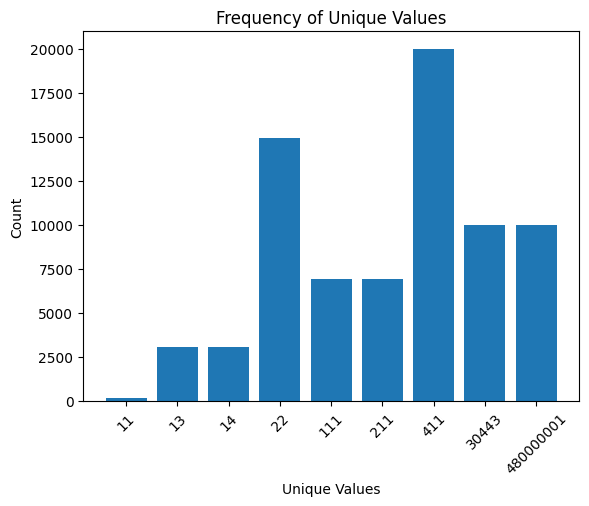

In [41]:
unique_values, counts = np.unique(primary_pdgid, return_counts=True)

unique_labels = [str(val) for val in unique_values]

# Plot
plt.bar(unique_labels, counts)
plt.xlabel("Unique Values")
plt.ylabel("Count")
plt.title("Frequency of Unique Values")

plt.xticks(rotation=45)  # Rotate labels if they are long
plt.show()

In [42]:
dict_counts = {unique_values[i]:counts[i] for i in range(len(unique_values))}

In [43]:
dict_counts

{11: 170,
 13: 3085,
 14: 3085,
 22: 14921,
 111: 6915,
 211: 6915,
 411: 20000,
 30443: 10000,
 480000001: 10000}

In [44]:
file[file.keys()[0]].keys()

[b'allGenParticles',
 b'allGenParticles#0',
 b'allGenParticles#1',
 b'allGenVertices',
 b'FarichBarrelG4Hits',
 b'FarichEndcapG4Hits',
 b'genVertices',
 b'secondaryPart',
 b'secondaryPart#0',
 b'secondaryPart#1']

In [45]:
file[file.keys()[0]]['FarichBarrelG4Hits'].keys()

[b'FarichBarrelG4Hits.cellId',
 b'FarichBarrelG4Hits.energy',
 b'FarichBarrelG4Hits.globalTime',
 b'FarichBarrelG4Hits.localTime',
 b'FarichBarrelG4Hits.preStepPosition.x',
 b'FarichBarrelG4Hits.preStepPosition.y',
 b'FarichBarrelG4Hits.preStepPosition.z',
 b'FarichBarrelG4Hits.postStepPosition.x',
 b'FarichBarrelG4Hits.postStepPosition.y',
 b'FarichBarrelG4Hits.postStepPosition.z',
 b'FarichBarrelG4Hits.trackId',
 b'FarichBarrelG4Hits.pdgId',
 b'FarichBarrelG4Hits.momentum.mass',
 b'FarichBarrelG4Hits.momentum.px',
 b'FarichBarrelG4Hits.momentum.py',
 b'FarichBarrelG4Hits.momentum.pz']

In [46]:
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())

In [47]:
farich_pdgid = np.concatenate(farich_pdgid)

In [48]:
farich_pdgid = np.abs(farich_pdgid)

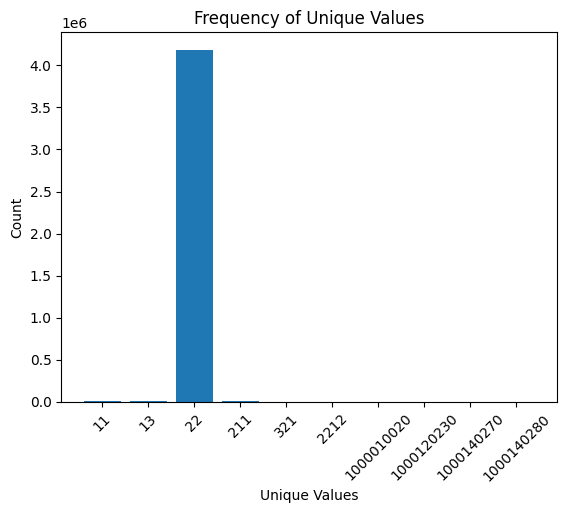

In [49]:
unique_values, counts = np.unique(farich_pdgid, return_counts=True)

unique_labels = [str(val) for val in unique_values]

# Plot
plt.bar(unique_labels, counts)
plt.xlabel("Unique Values")
plt.ylabel("Count")
plt.title("Frequency of Unique Values")

plt.xticks(rotation=45)  # Rotate labels if they are long
plt.show()

In [50]:
farich_dict_counts = {unique_values[i]:counts[i] for i in range(len(unique_values))}

In [51]:
farich_dict_counts

{11: 7483,
 13: 2537,
 22: 4187390,
 211: 5406,
 321: 3,
 2212: 159,
 1000010020: 3,
 1000120230: 1,
 1000140270: 1,
 1000140280: 3}

In [52]:
1145+963

2108

In [53]:
farich_energy = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.energy'].array())
farich_momentum_x = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.px'].array())
farich_momentum_y = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.py'].array())
farich_momentum_z = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.momentum.pz'].array())
farich_pdgid = np.array(file[file.keys()[0]]['FarichBarrelG4Hits']['FarichBarrelG4Hits.pdgId'].array())


In [54]:
max(farich_energy[0] * 1e9)

89108.49869719332

In [55]:
np.array(np.sqrt(farich_momentum_x[0] ** 2 + farich_momentum_y[0] ** 2 + farich_momentum_z[0] ** 2) * 1e9)[np.sqrt(farich_momentum_x[0] ** 2 + farich_momentum_y[0] ** 2 + farich_momentum_z[0] ** 2) * 1e9 > 10]

array([4.6999366e+08, 4.3658026e+08, 8.6729350e+08], dtype=float32)

In [56]:
np.sqrt(farich_momentum_x[0] ** 2 + farich_momentum_y[0] ** 2 + farich_momentum_z[0] ** 2) * 1e9

array([2.5433784e+00, 2.6947298e+00, 3.0389357e+00, ..., 4.8975196e+00,
       2.2587888e+00, 8.6729350e+08], dtype=float32)

In [77]:
farich_pdgid[0]

array([-22, -22, -22, ..., -22, -22, 211])

In [71]:
np.unique(farich_pdgid[0], return_counts=True)

(array([-22, -11,  11, 211]), array([1482,    1,    1,    1], dtype=int64))

In [58]:
# primary_energy = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.energy'].array())
primary_momentum_x = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.px'].array())
primary_momentum_y = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.py'].array())
primary_momentum_z = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.p4.pz'].array())
primary_pdgid = np.array(file[file.keys()[0]]['allGenParticles']['allGenParticles.core.pdgId'].array())


In [59]:
np.array(np.sqrt(primary_momentum_x[0] ** 2 + primary_momentum_y[0] ** 2 + primary_momentum_z[0] ** 2) * 1e9)#[np.sqrt(primary_momentum_x[0] ** 2 + primary_momentum_y[0] ** 2 + primary_momentum_z[0] ** 2) * 1e9 > 10]


array([0.0000000e+00, 2.5243550e+08, 8.7049094e+08, 9.9586048e+08,
       4.3941814e+08, 4.7230304e+08, 9.3244352e+07, 2.5243550e+08,
       2.5243550e+08], dtype=float32)

In [60]:
primary_pdgid[5]

array([    30443,       411,       211,       111,        22,        22,
              22,      -411, 480000001])